# TODO:


*   Make the wrapper clearer and easier to read
* get_action -> Epsilon Greedy
* train loop
* save weights
* load weight
* play game


In [42]:
import gym
import numpy as np

# **Auswahl des Spiels**

[Hier](https://gym.openai.com/envs/#atari) ist eine vollständige Liste der verfügbaren Spiele zu finden. Um ein Environment zu erstellen muss der vollständige Name des Spiels als String übergeben werden.

Beispiel:

```python
game = "MsPacman-v0"
```

In [63]:
# Hier kann das Spiel übergeben werden
game = "Assault-v0"

# **Preprocessing**
[Stable Baselines](https://github.com/openai/baselines/blob/master/baselines/common/atari_wrappers.py)


### Fire Wrapper

In [44]:
class FireResetEnv(gym.Wrapper):
    def __init__(self, env):
        gym.Wrapper.__init__(self, env) 
        self.env.reset()

    def reset(self, **kwargs):
        self.env.reset(**kwargs)
        observation, _, _, _ = self.env.step(env.unwrapped.get_action_meanings().index('FIRE'))

        return observation

### Frame Stack Wrapper

In [45]:
class LazyFrames(object):
    def __init__(self, frames):
        """
        This object ensures that common frames between the observations are only stored once.
        It exists purely to optimize memory usage which can be huge for DQN's 1M frames replay
        buffers.
        This object should only be converted to np.ndarray before being passed to the model.
        :param frames: ([int] or [float]) environment frames
        """
        self._frames = frames
        self._out = None

    def _force(self):
        if self._out is None:
            self._out = np.concatenate(self._frames, axis=2)
            self._frames = None
        return self._out

    def __array__(self, dtype=None):
        out = self._force()
        if dtype is not None:
            out = out.astype(dtype)
        return out

    def __len__(self):
        return len(self._force())

    def __getitem__(self, i):
        return self._force()[i]

In [46]:
from collections import deque

class FrameStack(gym.Wrapper):
    def __init__(self, env, n_frames=4):
        """Stack n_frames last frames.
        Returns lazy array, which is much more memory efficient.
        See Also
        --------
        stable_baselines.common.atari_wrappers.LazyFrames
        :param env: (Gym Environment) the environment
        :param n_frames: (int) the number of frames to stack
        """
        gym.Wrapper.__init__(self, env)
        self.n_frames = n_frames
        self.frames = deque([], maxlen=n_frames)
        shp = env.observation_space.shape
        self.observation_space = spaces.Box(low=0, high=255, shape=(shp[0], shp[1], shp[2] * n_frames),
                                            dtype=env.observation_space.dtype)

    def reset(self, **kwargs):
        obs = self.env.reset(**kwargs)
        for _ in range(self.n_frames):
            self.frames.append(obs)
        return self._get_ob()

    def step(self, action):
        obs, reward, done, info = self.env.step(action)
        self.frames.append(obs)
        return self._get_ob(), reward, done, info

    def _get_ob(self):
        assert len(self.frames) == self.n_frames
        return LazyFrames(list(self.frames))

### Resize & Grayscale Wrapper

Bild nicht Grauwert -> [stackoverflow](https://stackoverflow.com/questions/51303361/color-rgb2gray-gives-none-grayscale-image-might-be-an-issue-with-jupyter-notebo)
```python
cmap = "gray" # while plotting
```

In [47]:
from gym import spaces
import cv2

class WarpFrame(gym.ObservationWrapper):
    def __init__(self, env):
        """
        Warp frames to 84x84 as done in the Nature paper and later work.
        :param env: (Gym Environment) the environment
        """
        gym.ObservationWrapper.__init__(self, env)
        self.width = 84
        self.height = 84
        self.observation_space = spaces.Box(low=0, high=255, shape=(self.height, self.width, 1),
                                            dtype=env.observation_space.dtype)
        
    def observation(self, frame):
        """
        returns the current observation from a frame
        :param frame: ([int] or [float]) environment frame
        :return: ([int] or [float]) the observation
        """
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        frame = cv2.resize(frame, (self.width, self.height), interpolation=cv2.INTER_AREA)
        return frame[:, :, None]

In [64]:
def make_env(env_name):
  env = gym.make(env_name)
  env = WarpFrame(env)
  if 'FIRE' in env.unwrapped.get_action_meanings():
    env = FireResetEnv(env)
  env = FrameStack(env)
  return env

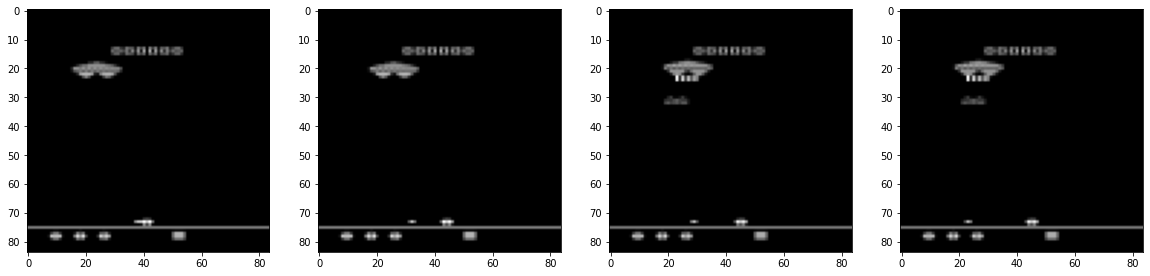

In [67]:
from matplotlib import pyplot as plt
import numpy as np

# Environment erstellen und auf Startzustand zurücksetzen
env = make_env(game)
env.reset()

for _ in range(1, 5):
  # Führe eine zufällige Aktion aus
  state, _, _, _ = env.step(env.action_space.sample())
state = np.array(state)

# Frame Strack plotten
fig, axs = plt.subplots(1,4, figsize=(20, 5))
for i in range(state.shape[2]):
  axs[i].imshow(state[:, :, i], cmap="gray")
plt.show()


# **Deep Q-Network und Target Network**

 *\"The input to
the neural network consists of an 84x84x4 image produced by the preprocessing
map **--w-- (falsche Darstellung)**. The first hidden layer convolves 32 filters of 8x8 with stride 4 with the
input image and applies a rectifier nonlinearity. The second hidden layer convolves
64 filters of 4x4 with stride 2, again followed by a rectifier nonlinearity.
This is followed by a third convolutional layer that convolves 64 filters of 333 with
stride 1 followed by a rectifier. The final hidden layer is fully-connected and consists
of 512 rectifier units. The output layer is a fully-connected linear layer with a
single output for each valid action. The number of valid actions varied between 4
and 18 on the games we considered."*


[Mnih, V., Kavukcuoglu, K., Silver, D. et al. Human-level control through deep reinforcement learning. Nature 518, 529–533 (2015).](https://www.nature.com/articles/nature14236)

In [54]:
import tensorflow as tf
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import RMSprop

# DQN und Tagret Net Parameters
INPUT_SHAPE = state.shape # (Höhe, Breite, Frames)
OUTPUT_SHAPE = env.action_space.n # Anzahl der möglichen Aktionen
LOSS_FUNCTION = Huber()
OPTIMIZER = RMSprop(learning_rate=0.00025, rho=0.95, epsilon=0.01)

# Funktion zum erstellen eines neuronalen Netzes
def build_neural_net(INPUT_SHAPE, OUTPUT_SHAPE, LOSS_FUNCTION, OPTIMIZER):
  net_input = Input(shape=INPUT_SHAPE)
  x = Conv2D(filters=32, kernel_size=(8, 8), strides=(4, 4), padding="same")(net_input)
  x = Activation("relu")(x)
  x = Conv2D(filters=64, kernel_size=(4, 4), strides=(2, 2), padding="same")(x)
  x = Activation("relu")(x)
  x = Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding="same")(x)
  x = Activation("relu")(x)
  x = Flatten()(x)
  x = Dense(256)(x)
  x = Activation("relu")(x)
  net_output = Dense(OUTPUT_SHAPE)(x)

  model = Model(inputs=net_input, outputs=net_output)
  model.compile(loss=LOSS_FUNCTION, optimizer=OPTIMIZER)

  return model

# Deep Q-Network
DQN = build_neural_net(INPUT_SHAPE, OUTPUT_SHAPE, LOSS_FUNCTION, OPTIMIZER)
# Target Network
TARGET = build_neural_net(INPUT_SHAPE, OUTPUT_SHAPE, LOSS_FUNCTION, OPTIMIZER)

# **Memory Buffer und Experience Replay**

In [ ]:
MEMORY_SIZE = 1000000
MEMORY_BUFFER = collections.deque(maxlen=MEMORY_SIZE)
TRAIN_START = 1000

# Speichert Transition von einem State in einen Folgestate
def save_transition(state, action, reward, next_state, done):
  MEMORY_BUFFER.append([state, action, reward, next_state, done])

In [ ]:
MINIBATCH_SIZE = 32
GAMMA = 0.96

def replay():
  # Speicher enthält nnicht genügend Transitionen für das Training
  if len(MEMORY_BUFFER < TRAIN_START):
    return

  # Trainieren
  # Ziehe 32 (MINIBATCH_SIZE) zufällige Transitionen aus dem Buffer in einen Minibatch
  minibatch = random.sample(MEMORY_BUFFER, MINIBATCH_SIZE)
  states, actions, rewards, next_states, dones = zip(*minibatch)

  states = np.concatenate(states)
  next_states = np.concatenate(next_states)

  q_values = DQN.predict(states)
  q_values_next = TARGET.predcit(next_states)

  # Q-Values Update
  for i in range(MINIBATCH_SIZE):
    a = actions[i]
    done = dones[i]
    if done:
      q_values[i][a] = rewards[i]
    else:
      q_values[i][a] = rewards[i] + GAMMA * np.max(q_values_next[i])

  DQN.model.train(states, q_values)